# Vogelmodel: A CNN for bird classification
Vogel is Dutch for bird- the name essentially means bird model. In this notebook I train a  CNNs on 200.000 photos that I scraped earlier (see vogelscraper.ipynb). 


**Jeffrey Luppes (jeffluppes@gmail.com)**

**Accompanying blog**: http://jeffluppes.github.io/2020/01/21/Building-a-bird-detector-from-scratch/

## Summary
This notebook first gathers images from folders and builds a datagenerators on top of these. The datagenerators (or datagens) are nice because you can 'stream' training data and perform augmentations on the original images. Images might be mirrored, or tilted by a couple of degrees to provide additional input. This is one way of coping with limited training data. Back when I first started this project I had very little data. 

I originally tried out different models and even a couple of pre-trained models. I was unable to have the pretrained models outperform a classic CNN, so I went with the classic CNN with the idea of coming back to the topic and implementing a better classification model. It is hard to train these models on a laptop in the middle of a heat wave in the summer, so training happened on K80 and P100 GPUs on Google Cloud.

I obtained ~72% top 1 accuracy with a model that was not converged yet. I also evaluated on some of my own photos. I included a classificationr report and confusion plot. I also explore what kind of areas the filters in the network respond to. 


Finally, I convert the model to TF lite (.tflite) to be able to run it on a raspberry pi. 

## NOTICE
This notebook is intended to be run on a GPU-enabled machine. **The scripts were executed on a Google Cloud Compute Engine running Jupyterhub, with access to a Nvidia Tesla K80 GPU.** While it is possible to do the same on a CPU I would not recommend it, as the training time is increased roughly 25x without a GPU. Scraping was done from another machine (you don't need a GPU for web scraping) and Google Cloud Storage was used as an impromptu repo to allow data transfer between both machines. 

## Improvements, TODOs, known issues...
This is not meant as the best possible model, but more of a first exploration. Some comments on improvements are mentioned throughout the notebook and I'm open to feedback. 

* Better models: seems obvious! Include some work from recent research seems like a good idea.
* Experiment with more data augmentations
* label all the plots and automatically scale their x and y axis

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

## Setting up

In [5]:
#the usual suspects
import numpy as np
import pandas as pd 
import random
import os

#tensorflow is my go-to deep learning library.
import tensorflow as tf

#sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#matplotlib for vizualisations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#opencv
import cv2

# warnings to mute warnings due to deprecated methods being used left and right
import warnings

In [70]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [6]:
#some settings
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

batch_size = 32

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data set splitting and data augmentation


In [42]:
labels = []
filenames = []

# create two lists with filenames and their labels 
# r=root, d=directories, f = files
for r, d, f in os.walk('../data/edited'):
    for file in f:

        if ".png" in file:
            labels.append(r.split('\\')[1])
            filenames.append(os.path.join(r, file))
            pass

In [43]:
# conver the lists to a dataframe
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

In [44]:
df['filename'].nunique()

200669

In [45]:
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

# uncomment this if you want a balanced sample.
#df = df.groupby('label').apply(sampling_k_elements).reset_index(drop=True)

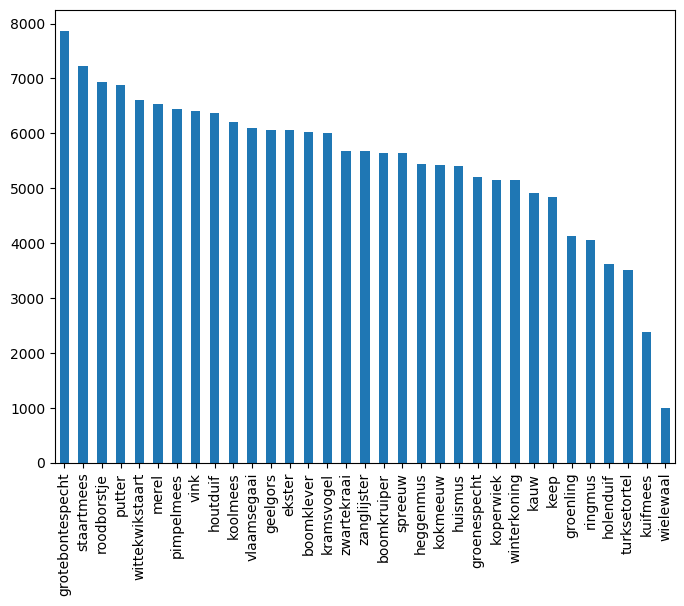

In [71]:
# show a quick graph breaking down the number of samples per species
df['label'].value_counts().plot.bar()

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200669 entries, 0 to 200668
Data columns (total 2 columns):
filename    200669 non-null object
label       200669 non-null object
dtypes: object(2)
memory usage: 3.1+ MB


In [49]:
# store the number of classes (used later for setting up the model)
num_classes = len(df.label.unique())

In [50]:
# 10% of the data will be used for a test set (a bit risky to say the least, but we dont have that much data)
df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# of the remaining 90%, 20% will be for validation during development
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [51]:
total_test = test_df.shape[0]
print('Total test samples: {}'.format(total_test))

Total test samples: 20067


In [52]:
total_train = train_df.shape[0]
print('Total training samples: {}'.format(total_train))

Total training samples: 144481


In [53]:
total_validate = validate_df.shape[0]
print('Total validation samples: {}'.format(total_validate))

Total validation samples: 36121


In [54]:
# set up a training datagen + generator that performs data augmentation on the go
# rescaling is needed to make sure that the colour values of each image are between 0 and 1
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 144481 validated image filenames belonging to 33 classes.


In [55]:
# Set up a validation datagenerator. No longer performing augmentations here.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 36121 validated image filenames belonging to 33 classes.


In [56]:
# for testing I also use a test generator. Only real difference here is 
# that the data is not shuffled (as I want to compute metrics on the test data)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 20067 validated image filenames belonging to 33 classes.


## Model training
I tried out a couple of architectures but figured models are pretty much plug and play. If a model needs to have a life outside this notebook there are plenty of challenges to solve first on the engineering side. It makes more sense to focus on getting the entire chain up and running, and then iterate over models. Also, cloud training is expensive.

In [42]:
def get_cnn():
    '''Returns a CNN as a keras model'''
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH ,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    model.summary()
    return model

In [43]:
#now grab the bigger model I defined earlier and define callbacks
model = get_cnn()

checkpoint = tf.keras.callbacks.ModelCheckpoint('cnn_v1', monitor='val_accuracy', verbose=0, save_best_only=True)
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [learning_rate_reduction, checkpoint]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [66]:
# commence training
history = model.fit(
    train_generator, 
    epochs=7,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/7
4515/4515 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.7034INFO:tensorflow:Assets written to: cnn_v1/assets


INFO:tensorflow:Assets written to: cnn_v1/assets


4515/4515 [==============================] - 5116s 1s/step - loss: 1.0043 - accuracy: 0.7034 - val_loss: 1.0747 - val_accuracy: 0.7101 - lr: 1.0000e-04
Epoch 2/7
4515/4515 [==============================] - 4657s 1s/step - loss: 0.9952 - accuracy: 0.7074 - val_loss: 1.1416 - val_accuracy: 0.6980 - lr: 1.0000e-04
Epoch 3/7
4515/4515 [==============================] - 4439s 983ms/step - loss: 0.9818 - accuracy: 0.7109 - val_loss: 1.2237 - val_accuracy: 0.6937 - lr: 1.0000e-04
Epoch 4/7
4515/4515 [==============================] - 4595s 1s/step - loss: 0.9716 - accuracy: 0.7128 - val_loss: 1.1803 - val_accuracy: 0.6920 - lr: 1.0000e-04
Epoch 5/7
4515/4515 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.7168INFO:tensorflow:Assets written to: cnn_v1/assets


INFO:tensorflow:Assets written to: cnn_v1/assets


4515/4515 [==============================] - 4393s 973ms/step - loss: 0.9600 - accuracy: 0.7168 - val_loss: 1.1204 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 6/7
4515/4515 [==============================] - ETA: 0s - loss: 0.9521 - accuracy: 0.7184INFO:tensorflow:Assets written to: cnn_v1/assets


INFO:tensorflow:Assets written to: cnn_v1/assets


4515/4515 [==============================] - 4383s 971ms/step - loss: 0.9521 - accuracy: 0.7184 - val_loss: 1.0298 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 7/7
4515/4515 [==============================] - 4462s 988ms/step - loss: 0.9487 - accuracy: 0.7196 - val_loss: 1.0850 - val_accuracy: 0.7162 - lr: 1.0000e-04


In [ ]:
#%tensorboard --logdir logs/fit

In [68]:
# Save the model (keras format)
model.save('birdmodel_v3.h5')

In [ ]:
# plot graphs of the training metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 17, 1))
ax1.set_yticks(np.arange(0, 4, 0.25))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 17, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [2]:
#load models if re-starting the notebook and not interested in retraining

from tensorflow.keras.models import load_model

model = load_model('birdmodel_v3.h5')
#model = load_model('bigger_model')
#vgg = load_model('vgg_model_full.h5')

In [3]:
from sklearn.metrics import confusion_matrix
import sklearn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [57]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_val = test_generator.classes

avg = 'weighted'

#print the accuracy score
print('accuracy: {}'.format(accuracy_score(y_val, y_pred)))

#add prediction results to dataframe
print('f1-score: {}'.format(f1_score(y_val, y_pred, average=avg)))
print('recall: {}'.format(recall_score(y_val, y_pred, average=avg)))
print('precision: {}'.format(precision_score(y_val, y_pred, average=avg)))
print('\n')

accuracy: 0.7494892111426721
f1-score: 0.7506952534358775
recall: 0.7494892111426721
precision: 0.7632793881514723




In [58]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [59]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

classnames = sorted([x for x in test_generator.class_indices])
print(classification_report(test_generator.classes, y_pred, target_names=classnames))

                  precision    recall  f1-score   support

      boomklever       0.83      0.83      0.83       673
     boomkruiper       0.67      0.89      0.77       641
          ekster       0.77      0.82      0.79       656
        geelgors       0.71      0.87      0.78       645
    groenespecht       0.83      0.77      0.80       619
       groenling       0.81      0.63      0.71       479
grotebontespecht       0.91      0.81      0.86       875
       heggenmus       0.73      0.72      0.72       589
       holenduif       0.65      0.65      0.65       395
        houtduif       0.73      0.73      0.73       694
         huismus       0.68      0.56      0.61       593
            kauw       0.70      0.57      0.63       526
            keep       0.86      0.69      0.77       520
        kokmeeuw       0.84      0.85      0.84       639
        koolmees       0.85      0.74      0.79       669
       koperwiek       0.78      0.64      0.70       599
      kramsvo

In [60]:
import pickle
pickle.dump(classnames, open( "birdclassnames.p", "wb" ) )

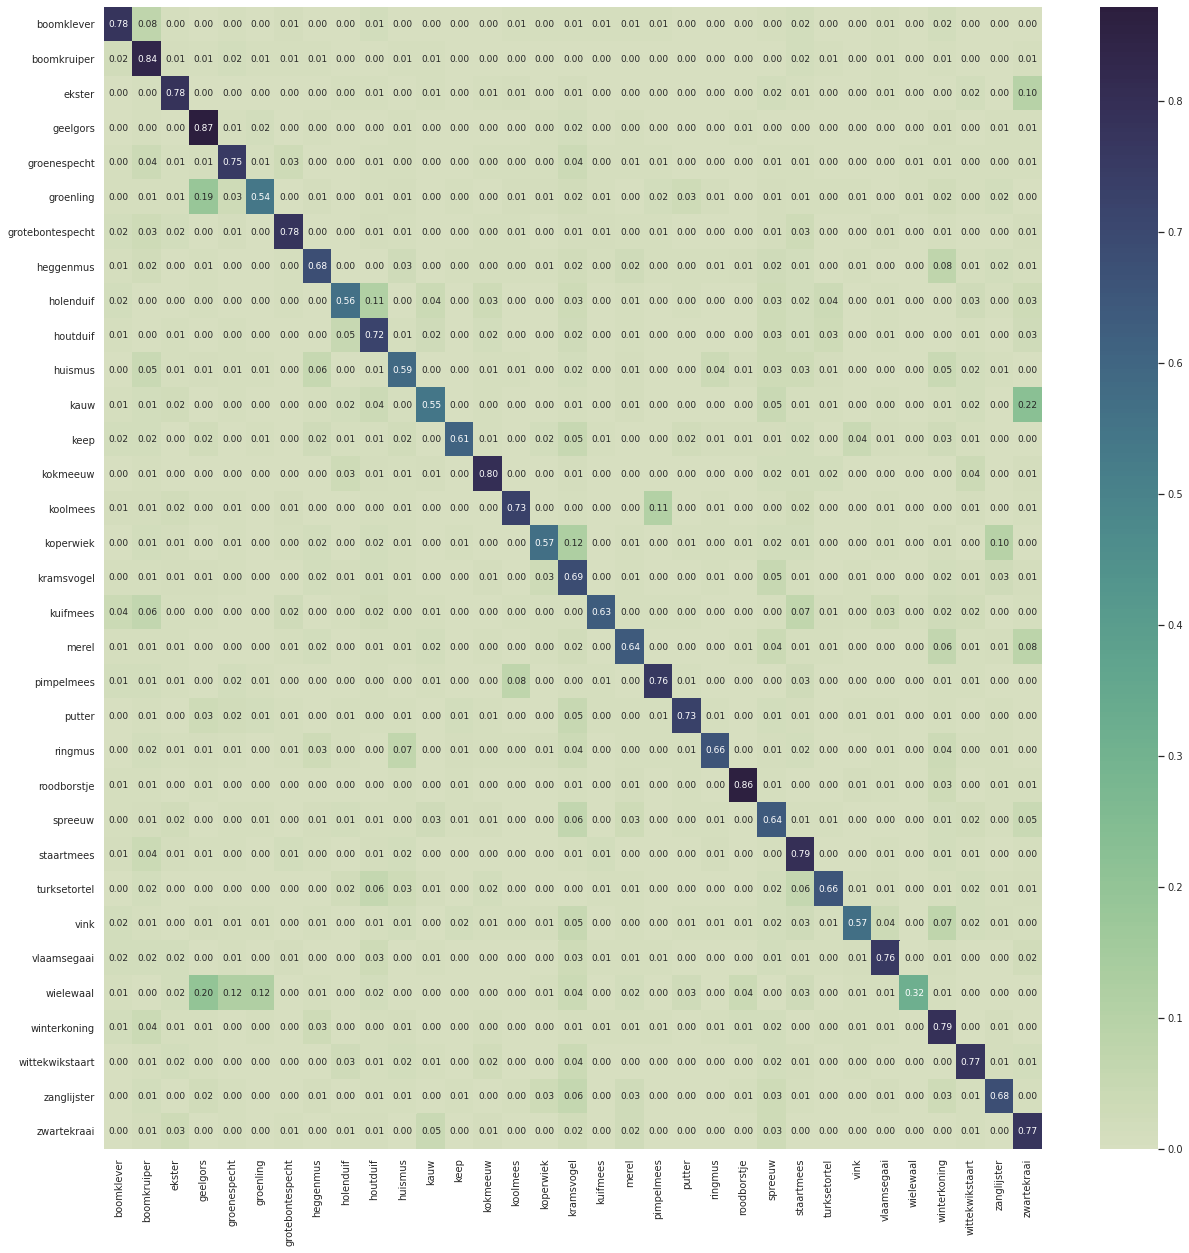

In [75]:
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
mat = confusion_matrix(test_generator.classes, y_pred, normalize='true')
df_cm = pd.DataFrame(mat, classnames, classnames)
plt.figure(figsize=(21,21))
sns.set(font_scale=0.9) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 9}, fmt='.2f', cmap=cmap) # font size

plt.show()

### Discussion on the basis of the confusion plot
I should be careful with a small test set like this, but I feel like a limited survey is fine. The confusion plot above shows that the model has trouble with some bird species that are also easily confused in the actual field. The blue and great tit (*pimpelmees and koolmees*) look a like so they're confused often, similarly, the three pigeon species also have some overlap as do the *fringilla* . The Turdus group (which includes the *kramsvogel*, the *merel* and the *zanglijster* are confused a lot, but they also get missclassified as a *spreeuw* which has a similar looking posture and chest albeit slightly different coloring. Some prominent mishaps are around the *wielewaal* and the *groenling*. Looking at the support from the classification report, there was not enough data for the model to learn to distinguish these. 

## Personal test images.
What found would this be if I couldn't test it on some real photos? Below are some of my own photos.

First I import some of the methods I used in the scraping script to pre-process the images:

In [24]:
def center_image(img):
    '''Convenience function to return a centered image'''
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [25]:
def convert_and_store_img(inputpath: str, outputpath: str):
    '''Converts an image and resizes it'''
    try:
        img = cv2.imread(inputpath)

        #opencv uses bgr instead of rgb, this is a quick conversion to fix this
        #img = img[:,:,::-1]

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = center_image(cv2.resize(img, dsize=tile_size))

        #output should be 224*224px for a quick vggnet16
        img = img[16:240, 16:240]

        cv2.imwrite(outputpath, img)
    except AttributeError as e:
        print(inputpath)
        print(e)

In [63]:
#get the images in the test directory
imgs = os.listdir('testimgs')

#just a quick list comprehension to weed out notebook checkpoints and temp files
testimgs = [img for img in imgs if '.jpg' in img.lower()] #if ('.jpg' in img.lower() or if '.png' in img.lower())]

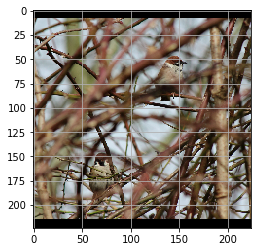

2015-02-23 14.36.43_e.JPG.png: verdict: ringmus (0.902885377407074 confidence)


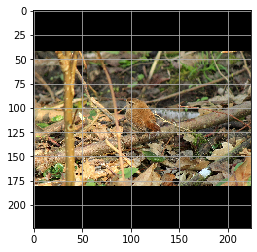

IMG_0021_e.JPG.png: verdict: winterkoning (0.9403635263442993 confidence)


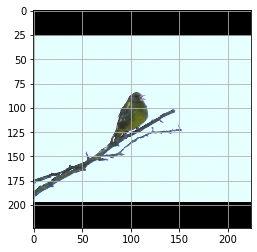

IMG_1240_e_groenling.JPG.png: verdict: groenling (0.7397590279579163 confidence)


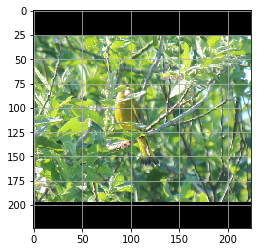

IMG_1250_e_groenling2.JPG.png: verdict: wielewaal (0.5025963187217712 confidence)


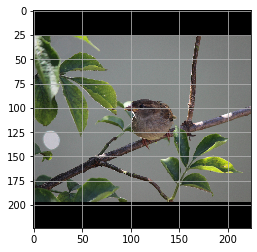

IMG_2012.JPG.png: verdict: heggenmus (0.8828713893890381 confidence)


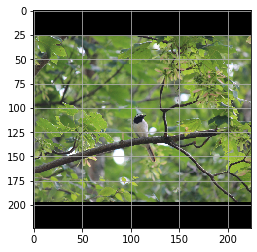

IMG_2190.JPG.png: verdict: staartmees (0.6535176038742065 confidence)


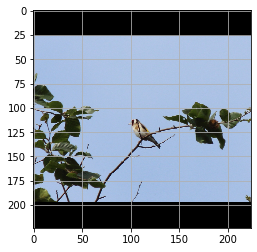

IMG_2284_e.JPG.png: verdict: putter (0.9266454577445984 confidence)


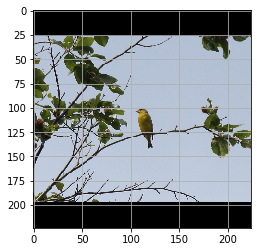

IMG_2294_e.JPG.png: verdict: groenling (0.5061710476875305 confidence)


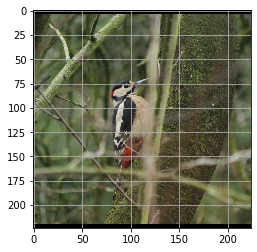

IMG_7735_e.JPG.png: verdict: grotebontespecht (1.0 confidence)


In [64]:
for testimg in testimgs:
    # show the raw image
    #img=mpimg.imread('testimgs/'+testimg)
    #imgplot = plt.imshow(img)
    #plt.show()
    
    # show the centered and 224x224 version
    # todo refactor it to use in-memory storage
    processed_img = testimg.split('\.')[0] + '.png'
    
    convert_and_store_img(f'testimgs/{testimg}', f'processed_testimgs/{processed_img}')
    img=mpimg.imread(f'processed_testimgs/{processed_img}')
    imgplot = plt.imshow(img)
    # toggle to remove the grid from photo plots
    plt.grid()
    plt.show()
    
    # get a prediction on this image
    #img /= 255
    preds = model.predict(np.expand_dims(img,0))

    print('{}: verdict: {} ({} confidence)'.format(processed_img, classnames[preds.argmax(axis=-1)[0]], preds[0][np.argmax(preds)]))

Not bad considering these are home-made images. I'm particularly impressed by the correct *winterkoning* label. I had assumed the bird to be labelled as a *heggemus* by the model. 

## Bonus: Showing model activation map

C:\Users\jeffl\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\jeffl\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


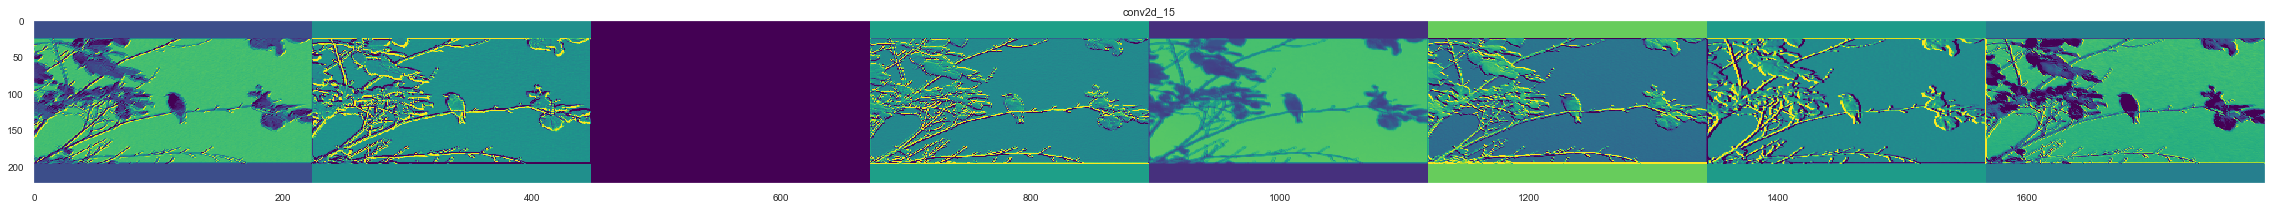

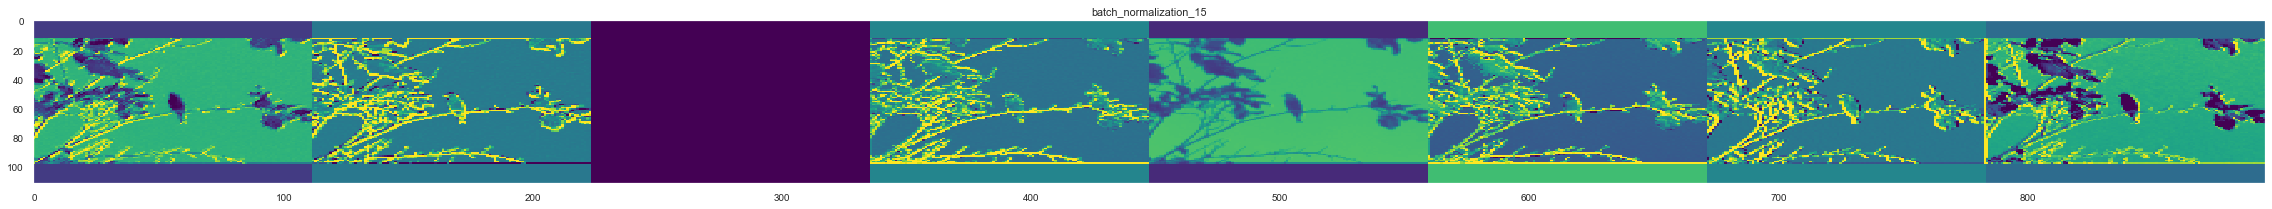

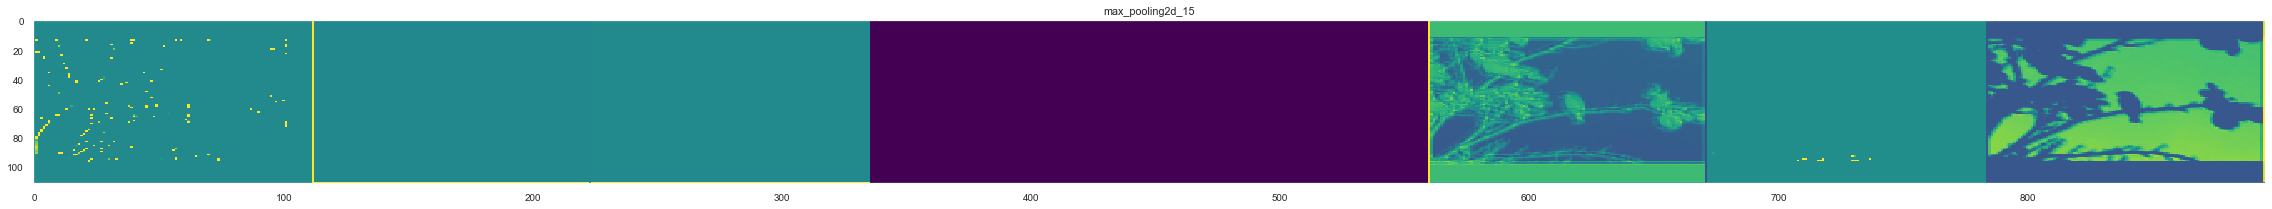

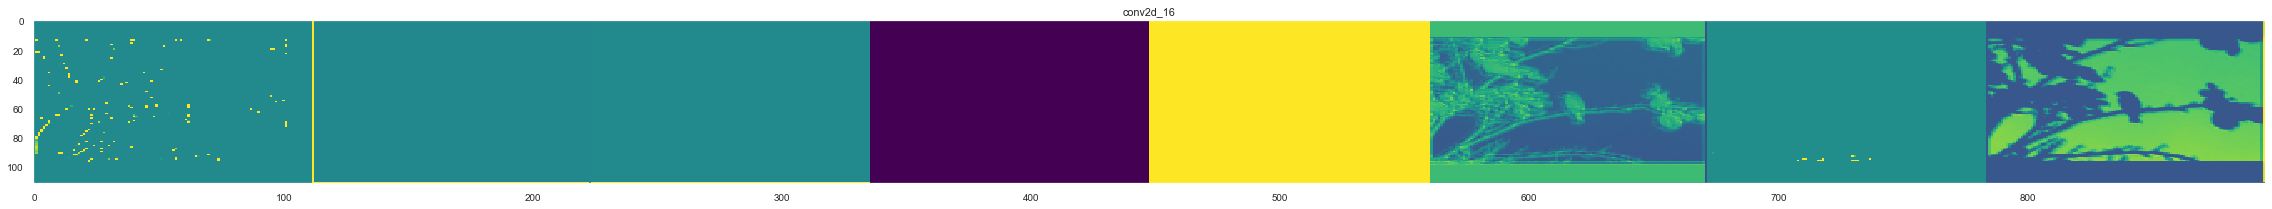

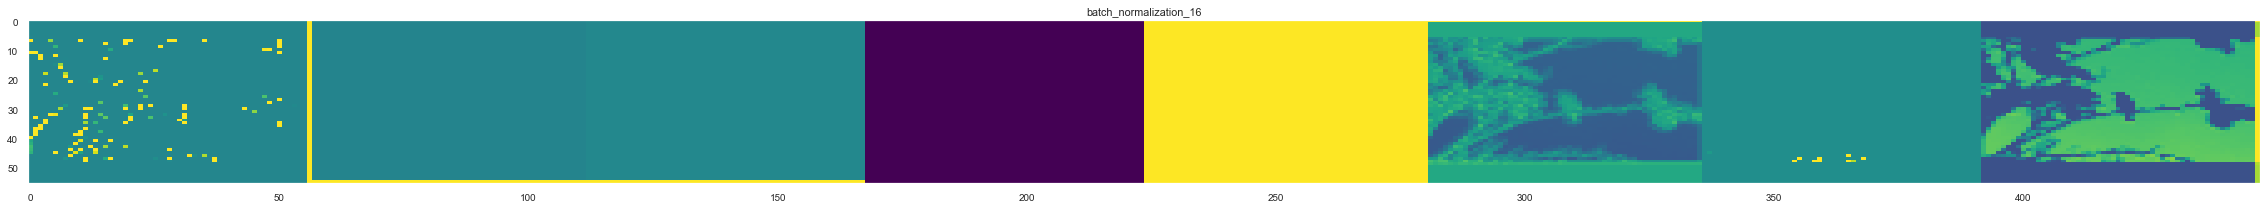

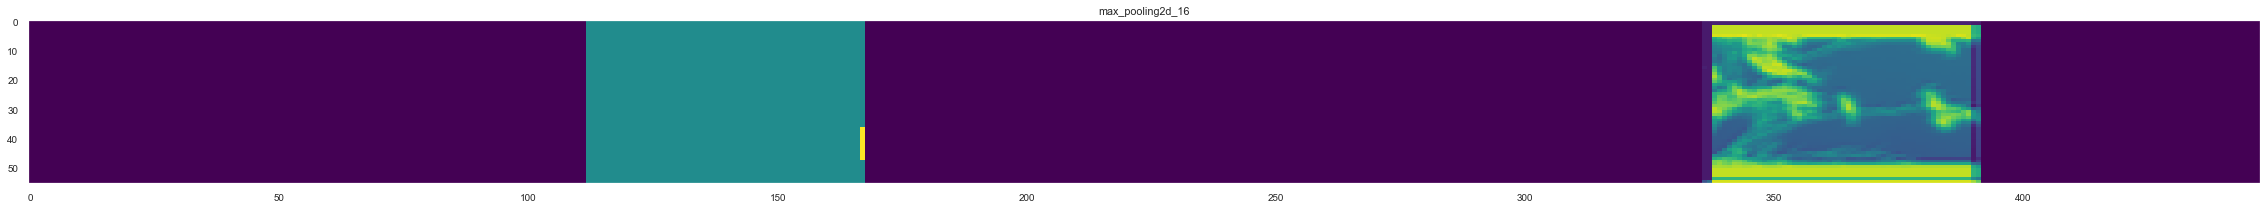

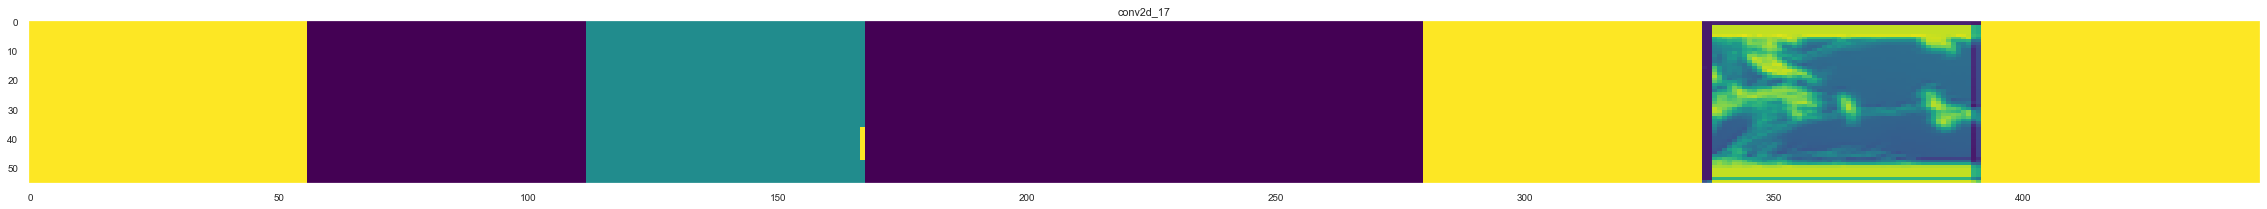

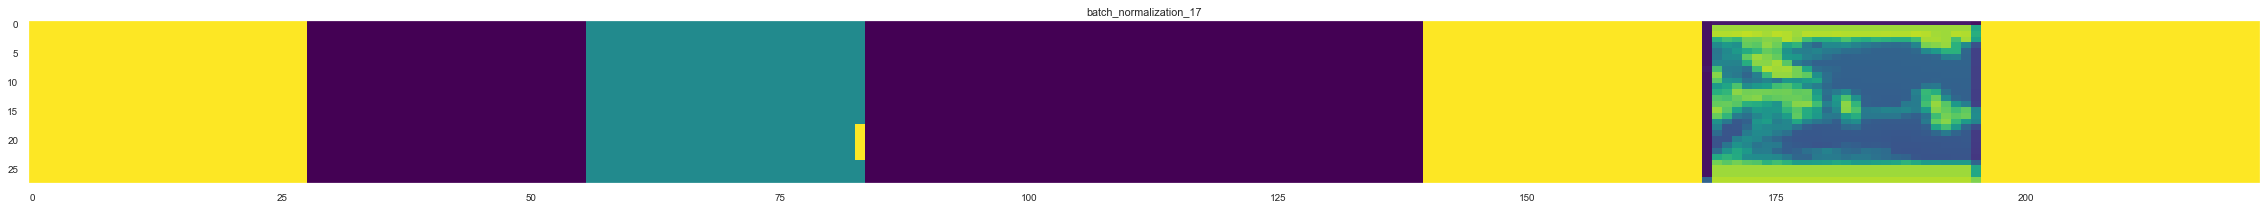

In [107]:
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image from the training set.

x = mpimg.imread('processed_testimgs/IMG_2294_e.JPG.png')
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * 8))
        
        for i in range(n_features)[:8]:
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
                
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(40,3))
        # plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


# A test on random static

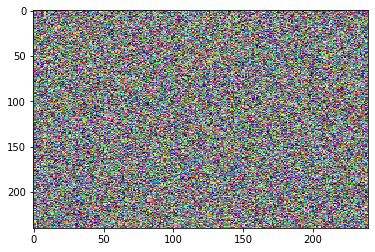

In [61]:
# create a random 240 x 240 x3 matrix
x = np.random.randint(1, 255, size=(240, 240, 3))

x = x.astype(float)

# normalize the matrix
x /= 255

# plot the matrix
plt.imshow(x, aspect='auto', cmap='viridis')

# resize the matrix

if(x.shape[0] > x.shape[1]):
    tile_size = (int(x.shape[1]*256/x.shape[0]),256)
else:
    tile_size = (256, int(x.shape[0]*256/x.shape[1]))

#centering
x = center_image(cv2.resize(x, dsize=tile_size))

#output should be 224*224px for a quick vggnet16
x = x[16:240, 16:240]

x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224, 224, 3
#get predictions
preds = model.predict([x])

In [62]:
classnames[preds.argmax(axis=-1)[0]]

'kramsvogel'

# TensorFlow Lite Preparation
So the tf lite models are a little bit special and need to be compiled first. We have two options: a quantized version (smaller, but worse accuracy) and a normal minimized version which will have weights pruned etc. Below I've included code for both.

In [67]:
# Convert the model to tf lite.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model (regular mode).
with tf.io.gfile.GFile('birdmodel.tflite', 'wb') as f:
    f.write(tflite_model)

# make a quant version of the same
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('birdmodel_quant_v2.tflite', 'wb') as f:
    f.write(tflite_quant_model)

In [53]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [62]:
# test a single prediction
classnames[tflite_results.argmax(axis=-1)[0]]

'ekster'